In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("AirQualityAnalysisIndia").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/07 11:00:14 WARN Utils: Your hostname, Karthikeya, resolves to a loopback address: 127.0.1.1; using 172.17.54.10 instead (on interface wlp1s0)
25/11/07 11:00:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/07 11:00:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
df_fe = spark.read.parquet('hdfs://localhost:9000/processed/enriched_air_quality.parquet')

In [13]:
window_spec = Window.partitionBy("City").orderBy("Date")

In [14]:
df_ml = df_fe.withColumn("pm2_5_next_day", lag("PM25", -1).over(window_spec))

In [9]:
df_ml = df_ml.dropna(subset=["PM25", "pm2_5_lag_1", "pm2_5_next_day"])

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `pm2_5_lag_1` cannot be resolved. Did you mean one of the following? [`City`, `Date`, `PM25`, `PM10`, `NO`, `NO2`, `NOx`, `NH3`, `CO`, `SO2`, `O3`, `Benzene`, `Toluene`, `AQI`, `AQI_Bucket`, `pm2_5_next_day`]. SQLSTATE: 42703

In [15]:
feature_cols = ["PM25", "pm2_5_lag_1", "pm2_5_rolling_avg_3","dayofweek", "month", "year"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_vector = assembler.transform(df_ml).select("features", "pm2_5_next_day")

IllegalArgumentException: [FIELD_NOT_FOUND] No such struct field `pm2_5_lag_1` in `City`, `Date`, `PM25`, `PM10`, `NO`, `NO2`, `NOx`, `NH3`, `CO`, `SO2`, `O3`, `Benzene`, `Toluene`, `AQI`, `AQI_Bucket`, `pm2_5_next_day`. SQLSTATE: 42704

In [11]:
train, test = df_vector.randomSplit([0.8, 0.2], seed=42)

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="pm2_5_next_day", regParam=0.1)
lr_model = lr.fit(train)

# predict
predictions = lr_model.transform(test)

# evaluate
evaluator = RegressionEvaluator(labelCol="pm2_5_next_day", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse:.2f}")

NameError: name 'df_vector' is not defined

In [48]:
predictions_pd = predictions.select("pm2_5_next_day", "prediction").toPandas()

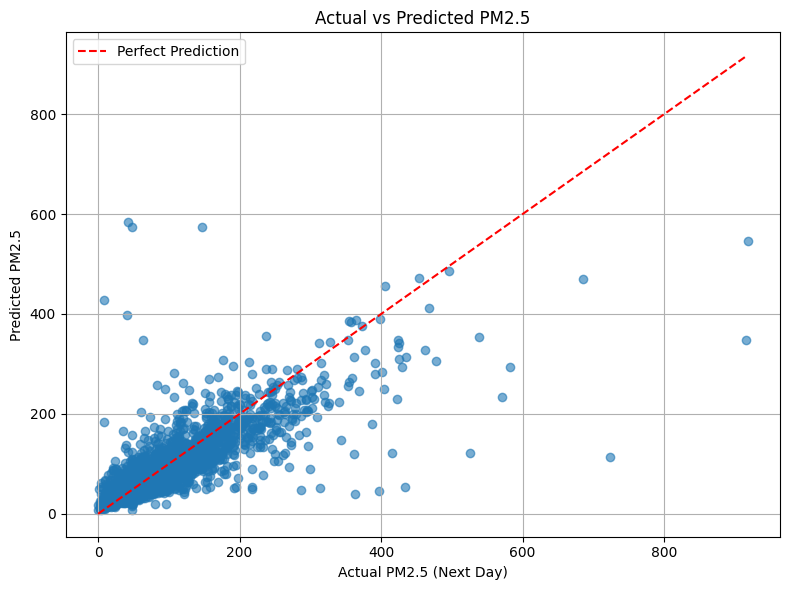

In [49]:

plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["pm2_5_next_day"], predictions_pd["prediction"], alpha=0.6)
plt.plot(
    [predictions_pd["pm2_5_next_day"].min(), predictions_pd["pm2_5_next_day"].max()],
    [predictions_pd["pm2_5_next_day"].min(), predictions_pd["pm2_5_next_day"].max()],
    color="red", linestyle="--", label="Perfect Prediction"
)
plt.xlabel("Actual PM2.5 (Next Day)")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

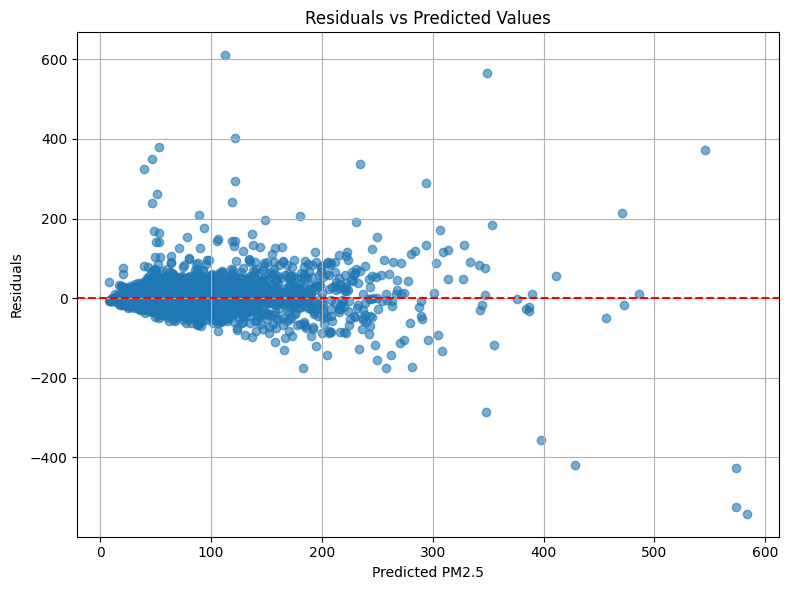

In [50]:
predictions_pd["residuals"] = predictions_pd["pm2_5_next_day"] - predictions_pd["prediction"]

plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["prediction"], predictions_pd["residuals"], alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

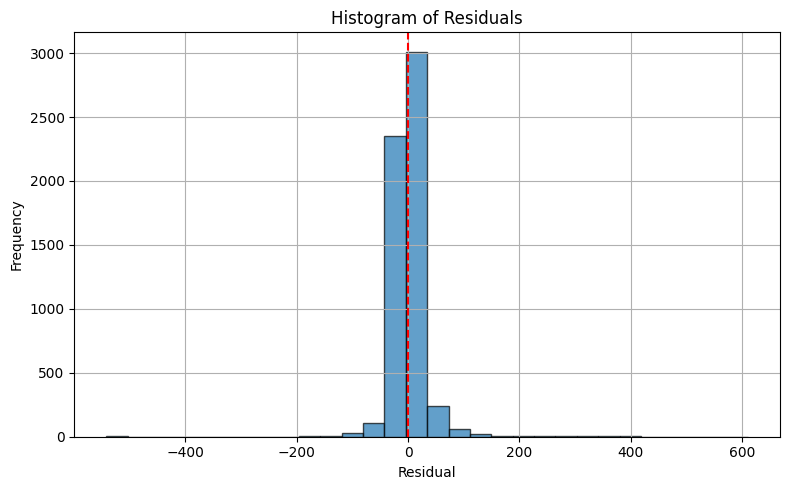

In [51]:
plt.figure(figsize=(8, 5))
plt.hist(predictions_pd["residuals"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--")
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
spark.stop()